In [1]:
# Setting optimal number of threads for kmeans:
%env OMP_NUM_THREADS=1
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, Javascript
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
import pylab
import os
# allow us to see results under cell code
%matplotlib inline

env: OMP_NUM_THREADS=1


### Set working directory:

#### Check current working directory:

In [2]:
pwd

'C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering'

#### Setting desire working directory
(Provide path to the folder containing the .csv file from fiji)

In [3]:
os.chdir('C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\tracks_f1_duzy')

#### Check if provided path leads to desired directory:

In [4]:
os.getcwd()

'C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\tracks_f1_duzy'

### Setting filenames:

#### tracks_df - .csv file from fiji (or imageJ) containing information about generated tracks from TrackMate plugin
#### spots_df - .csv file from fiji (or imageJ) containing information about spots whithin every track
#### directory_name - name of the new directory that the workflow will create containing all output information and generated data frames in the form of .csv files

In [5]:
tracks_df = 'tracks_f1_duzy_slabe_nieb_40uE.csv' 

spots_df = 'spots_f1_duzy_slabe_nieb_40uE.csv'

# Please stick with convention of naming example: "TA_training_csv"
directory_name ='TA_tracks_f1_duzy'

### Importing data from .csv to the data frame:

In [6]:
# Reading file with proper encoding form fiji:

raw_data = pd.read_csv(tracks_df, encoding = 'cp1250')
raw_data_spots = pd.read_csv(spots_df, encoding = 'cp1250')

# Fillling na values:
raw_data.fillna(0)

# Creating the df from interesting columns:
df_from_raw = raw_data[['LABEL', 'TRACK_ID','TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED',
                          'TRACK_STD_SPEED', 'TOTAL_DISTANCE_TRAVELED',
                          'CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED',
                          'LINEARITY_OF_FORWARD_PROGRESSION',
                          'MEAN_DIRECTIONAL_CHANGE_RATE']].copy()

C:\Users\Alek\AppData\Local\Temp\ipykernel_19992\1466722625.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_spots = pd.read_csv(spots_df, encoding = 'cp1250')


### Adjusting the data frame content: removing exces rows, converting types reseting index etc. 

In [7]:
# Droping first 3 row because of insuficient values:
df_dropped = df_from_raw.drop(df_from_raw.index[[0,1,2]])

# Setting the proper index order:
df_dropped = df_dropped.reset_index(level=None, drop=True)

# Setting proper data types of values:
# By use of to numeric it was able tooverlap the problem with commas.
df_w_floats = df_dropped.iloc[:, 2:10].apply(pd.to_numeric)
# We also adding the label column with the names of tracks changed to string
df_w_floats['LABEL'] = df_dropped['LABEL'].astype('string')
df_w_floats['TRACK_ID'] = df_dropped['TRACK_ID'].astype('int')
# df_w_floats.info()

# Creating sub-df without fiji labels:
df_no_Flabels = df_w_floats.copy()
df_no_Flabels = df_no_Flabels.drop(['LABEL', 'TRACK_ID'], axis = 1)
#df_no_Flabels.info()

### Making new directory for output provided by the workflow:

In [8]:
# getting the absolute path of the current working directory
current_dir = os.getcwd()

# creating path to new folder:
new_folder_path = os.path.abspath(os.path.join(current_dir, directory_name))

# Checking if the directory already exists
if not os.path.exists(new_folder_path): 
    # create the new folder
    os.mkdir(new_folder_path)
else:
    print(f"The directory {new_folder_path} already exists, using it instead.")
    
# set the new folder as the current working directory
os.chdir(new_folder_path)

# saving .csv to new folder:
df_w_floats.to_csv('df_w_floats.csv')
df_no_Flabels.to_csv('df_no_Flabes.csv')
raw_data_spots.to_csv('raw_spots_data.csv')

### Performing the spearman correlation of all features:

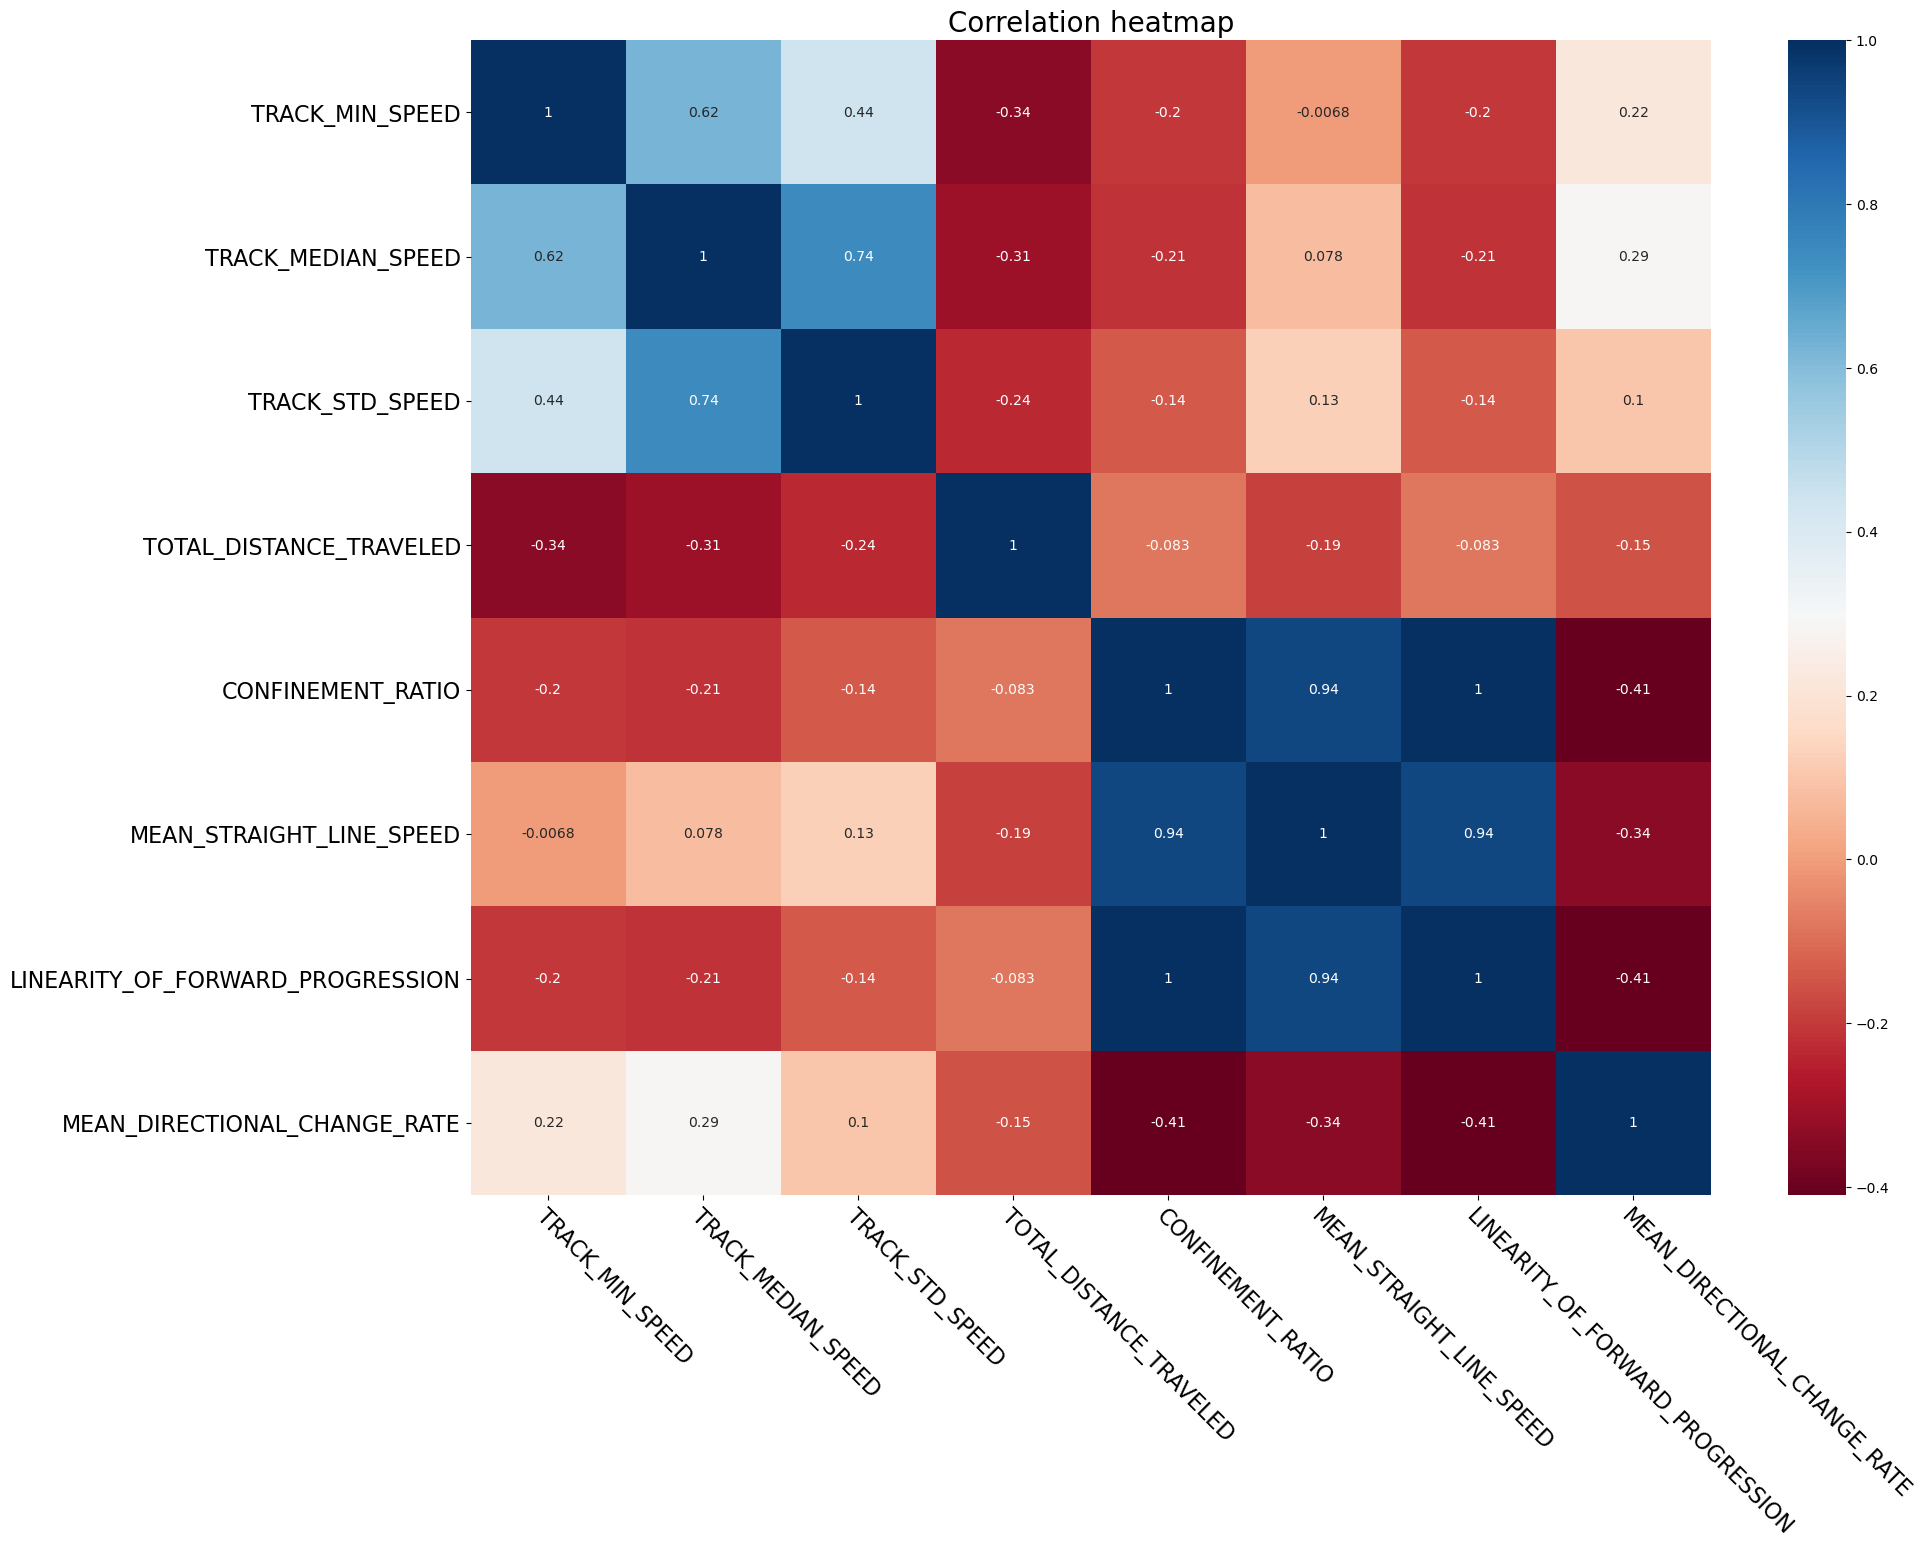

In [9]:
plt.figure(figsize=(20,15))
sns.heatmap(df_no_Flabels.corr(method='spearman'),
            annot=True, cmap='RdBu')
plt.title('Correlation heatmap', fontsize=20)
plt.yticks(rotation=0, fontsize = 16)
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor', fontsize = 16)
plt.savefig("heatmap_spearman_out.jpg")
plt.show()

### Performing scaling of the data:


In [10]:
# Scaling data with robust scaler:

# Creating robustscaler object:
scaler_robust = RobustScaler()

# Separating the label from data frame:
label = df_w_floats['LABEL']

# Fit and transform the feature data:
scaled_features = scaler_robust.fit_transform(df_no_Flabels)

# Creating new data frame with the scaled features and the label column:
df_scaled = pd.DataFrame(scaled_features, columns=df_no_Flabels.columns)
df_scaled.insert(0, 'Label', label)

# saving the scaled data to csv
df_scaled.to_csv("tracks_df_scaled.csv")

### Prepering data to clustering:

From further testing the best performance in clustering for this analysis
was achived by reducing dimensionality of data set to 2 features and limiting cluster numbers to 2 (all concluded testing is provided in another script free to use) but for checking different purposes all data frame was scaled and the functions will allow changeing the features to perform different outputs. 

List of all possible features to use:
1. TRACK_MIN_SPEED
2. TRACK_MEDIAN_SPEED
3. TRACK_STD_SPEED
4. TOTAL_DISTANCE_TRAVELED
5. CONFINEMENT_RATIO
6. MEAN_STRAIGHT_LINE_SPEED
7. LINEARITY_OF_FORWARD_PROGRESSION
8. MEAN_DIRECTIONA_CHANGE_RATE

For my analysis best performance was achived by using the features 5 and 7. Please have in considaration that it is possible to change and use of other features may yield different outcome.

In [11]:
# Setting the data frame for K-Means and hierarchical clustering:
df_to_clustering = df_scaled[['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED']].copy()

#### Performing K-Means clustering on fixed parameters:

In [12]:
def perform_k_means_clustering(df):
    # Performing kmeans for provided dataframe:
    # kmeans_fp - means fixed parameters
    kmeans_fp = KMeans(n_clusters = 2, init='k-means++', n_init = 50,
                      max_iter = 10000, random_state = 1)
    kmeans_fp.fit_predict(df)
    
    # Getting the labels and centroids:
    labels = kmeans_fp.labels_
    centroids = kmeans_fp.cluster_centers_
    
    return labels, centroids 

In [13]:
def plot_kmeans(labels, data, centroids):
    
    """
    Plots the data points and centroids for KMeans clustering.

    Args:
    labels (numpy.ndarray): The cluster labels for each data point.
    data (pandas.DataFrame): The input data used for clustering.
    centroids (numpy.ndarray): The centroids of each cluster.

    Returns:
    None
    """
    try:
        # Check that labels are a numpy aray:
        if not isinstance(labels, np.ndarray):
            raise TypeError('Labels must be a numpy array.')
        
        # Check that the data is a pandas Data frame:
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the centroids are a numpy array:
        if not isinstance(centroids, np.ndarray):
            raise TypeError('Centroids must be a numpay array')
            
        # Check that the data and the centroids have two columns:
        if data.shape[1] != 2 or centroids.shape[1] != 2:
            raise ValueError("Data and centroids must have two columns")
        
        # Creating the scatter plot od the data points:
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c = labels, cmap = 'viridis')

        # Ploting the centroids as black stars:
        plt.scatter(centroids[:, 0], centroids[:, 1], c ='black', marker = '*',
                   s = 150)

        list_of_features = list(data.columns)
        # Set the axis:
        plt.title(f"KMeans clustering\n({list_of_features[0]} vs. {list_of_features[1]})")
        plt.xlabel(list_of_features[0])
        plt.ylabel(list_of_features[1])
        
        # Saving the plot:
        plt.savefig(f'kmeans_{list_of_features[0]}_vs_{list_of_features[1]}.png')

        # Showing the plot:
        plt.show()
    
    except Exception as e:
        print(f"An error occured: {e}")

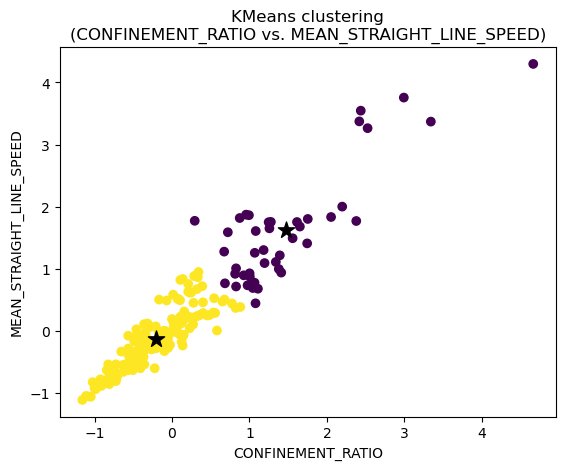

In [14]:
labels, centroids = perform_k_means_clustering(df_to_clustering)
plot_kmeans(labels, df_to_clustering, centroids)

#### Performing hierarchical clustering:

In [15]:
def hierarchical_clustering(df: pd.DataFrame):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the data and the centroids have two columns:
        if df.shape[1] != 2:
            raise ValueError("Data must have two columns")
        
        # Calculate the pairwise distance matrix
        dist_matrix = linkage(df.values, method='ward', metric='euclidean')
        
        # Plot the dendrogram:
        plt.title(f"Dendrogram of hierarchical clustering \n({df.columns[0]} vs. {df.columns[1]})")
        dendrogram(dist_matrix)
        plt.xlabel('Data points')
        plt.ylabel('Distance')
        
        # Fit the AgglomerativeClustering model to the data
        model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
        model.fit(df)
        
        # Get the cluster labels from the model
        clusters = model.labels_
        
        plt.savefig(f'dendrogram_{df.columns[0]}_vs_{df.columns[1]}.png')
        
        return dist_matrix, clusters
    
    except Exception as e:
        print(f"An error occurs: {e}")

In [16]:
def plot_hierarchical_data(df, labels):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the data and the centroids have two columns:
        if df.shape[1] != 2:
            raise ValueError("Data must have two columns")
            
        # Plot the clustered data
        plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c = labels, cmap = 'viridis')
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
        plt.title(f"Hierarchical Clustering \n({df.columns[0]} vs. {df.columns[1]})")
        plt.savefig(f"hierarchical_{df.columns[0]}_vs_{df.columns[1]}.png")
        plt.show()
        
    except Exception as e:
        print(f"An error occurs: {e}") 

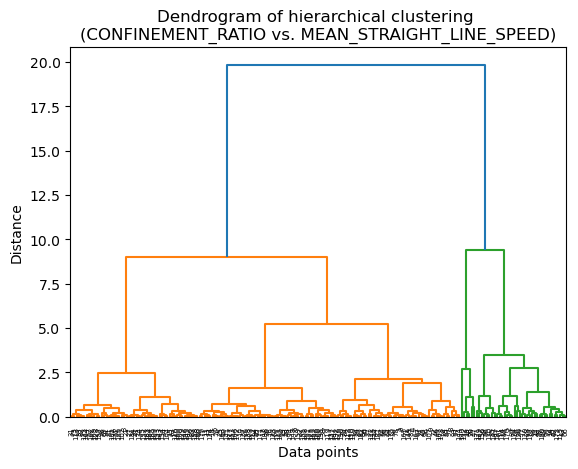

In [17]:
dist_matrix, hierarchical_labels = hierarchical_clustering(df_to_clustering)

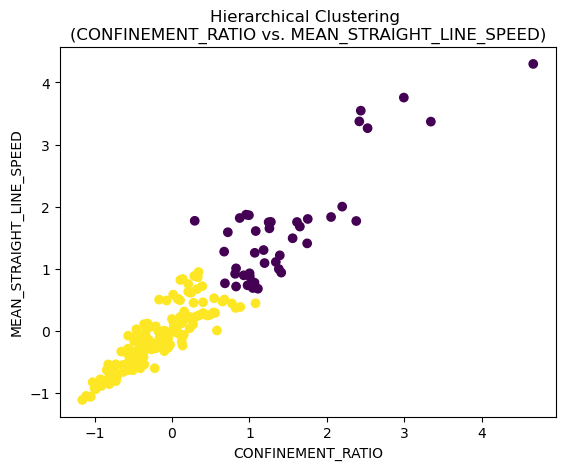

In [18]:
plot_hierarchical_data(df_to_clustering, hierarchical_labels)

#### Sorting the track_names by the clustering group:

##### Kmeans:

In [19]:
def get_kmeans_groups(df_w_track_names, cluster_labels):
    df = pd.DataFrame(df_w_track_names['Label'].copy())
    df['Cluster_labels'] = cluster_labels
    
    # Group the data by the cluster_labels column and get the list of track names
    # for each cluster:
    cluster_dict = df.groupby('Cluster_labels')['Label'].apply(list).to_dict()
    
    return cluster_dict

In [20]:
kmeans_dict = get_kmeans_groups(df_scaled, labels)

##### Hierarchical:

In [21]:
def get_hierarchical_groups(df_w_track_names, hierarchical_labels):
    df = pd.DataFrame(df_w_track_names['Label'].copy())
    df['Cluster_labels'] = hierarchical_labels
    
    # Group the data by the cluster_labels column and get the list of track names
    # for each cluster:
    cluster_dict = df.groupby('Cluster_labels')['Label'].apply(list).to_dict()
    
    return cluster_dict

In [22]:
hierarchical_dict = get_hierarchical_groups(df_scaled, hierarchical_labels)

#### Creating data frames with columns taken to the clustring and their label values:

In [23]:
# For Kmeans:
df_after_kmeans = pd.DataFrame(df_to_clustering.copy())
df_after_kmeans['Cluster_labels'] = labels

# For hierarchical:
df_after_hierarchical = pd.DataFrame(df_to_clustering.copy())
df_after_hierarchical['Cluster_labels'] = hierarchical_labels

### Comparison the groups after clustering:

#### Performing pie plot of the clusters after kmeans

In [24]:
from collections import Counter

def plot_clusters_pie(cluster_dict: dict, algorithm_name: str):
    try:
        # Count the number of elements in each cluster:
        cluster_counts = Counter({k: len(v) for k, v in cluster_dict.items()})
        
        # Create a pie plot:
        labels = [f'Clusters {k}' for k in cluster_counts.keys()]
        sizes = list(cluster_counts.values())
        
        # Setting to show the number of tracks in each group:
        def autopct_func(pct):
            total = sum(cluster_counts.values())
            count = int(round(pct*total/100))
            return f'{pct:.1f}%\n({count})'
        
        plt.pie(sizes, labels = labels, autopct = autopct_func)
        plt.axis('equal')
        plt.title(f'Group distribution after {algorithm_name}')
        plt.savefig(f'pie_plot_of_{algorithm_name}_groups.png')
        plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.close()

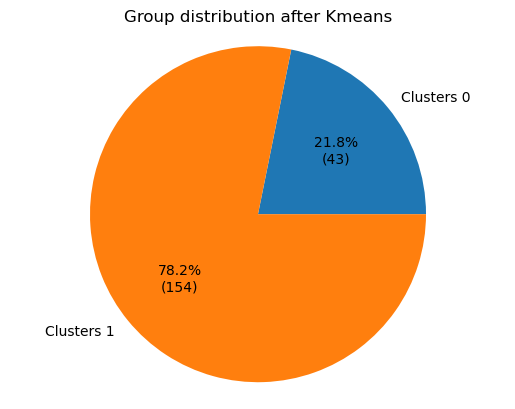

In [25]:
plot_clusters_pie(kmeans_dict, 'Kmeans')

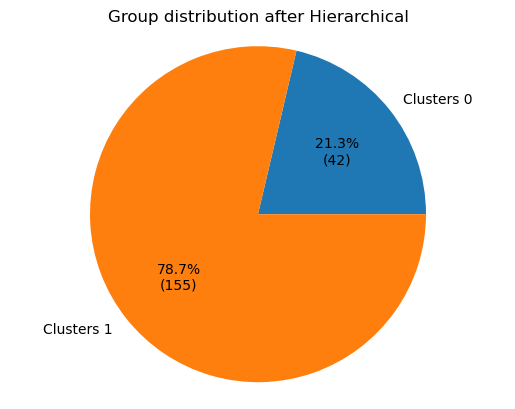

In [26]:
plot_clusters_pie(hierarchical_dict, 'Hierarchical')

#### Comparing the cluster groups:

In [27]:
def compare_dicts(dict1, dict2):
    try:
        # get the common keys from both dictionaries
        common_keys = set(dict1.keys()) & set(dict2.keys())

        # compare the values of each common key
        for key in common_keys:
            if dict1[key] != dict2[key]:
                # find the differences between the two lists
                set1 = set(dict1[key])
                set2 = set(dict2[key])
                differences = set1.symmetric_difference(set2)

                # print the key and the differing values
                print(f"Differences in group {key}:")
                for val in differences:
                    if val in set1 and val not in set2:
                        print(f"Value '{val}' only in first dictionary")
                    elif val in set2 and val not in set1:
                        print(f"Value '{val}' only in second dictionary")
            else:
                print(f"Group {key} is identical in both dictionaries")

        # print the keys that are only present in one dictionary
        keys_only_in_dict1 = set(dict1.keys()) - common_keys
        keys_only_in_dict2 = set(dict2.keys()) - common_keys
        if keys_only_in_dict1:
            print(f"The following groups are only in the first dictionary: {keys_only_in_dict1}")
        if keys_only_in_dict2:
            print(f"The following groups are only in the second dictionary: {keys_only_in_dict2}")
    except Exception as e:
        print(f"An errot occured: {e}")

In [28]:
# Calling compare dicts to chcek the differences in the cluster groups:
compare_dicts(kmeans_dict, hierarchical_dict)

Differences in group 0:
Value 'Track_15' only in first dictionary
Differences in group 1:
Value 'Track_15' only in second dictionary


#### Comparing features accros the clusters:

In [29]:
def plot_boxplot_sns(df, algorithm_name: str):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')

        # Getting the names of the features to avoid hard coding the names:
        feature_names = list(df.columns)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        data_0 = df[df[str(feature_names[2])] == 0][[str(feature_names[0]), str(feature_names[1])]]
        data_1 = df[df[str(feature_names[2])] == 1][[str(feature_names[0]), str(feature_names[1])]]

        # Calculating the standard deviation for whiskers:
        std_0 = data_0.std().values
        std_1 = data_1.std().values

        axs[0] = sns.boxplot(data=[data_0[str(feature_names[0])], data_1[str(feature_names[0])]], 
                             ax=axs[0], notch=True, whis=(std_0[0], std_0[0]) )
        axs[1] = sns.boxplot(data=[data_0[str(feature_names[1])], data_1[str(feature_names[1])]], 
                             ax=axs[1], notch=True, whis=(std_1[0], std_1[0]) )

        axs[0].set_title(f"{feature_names[0]} by Cluster")
        axs[1].set_title(f"{feature_names[1]} by Cluster")
        plt.savefig(f'{algorithm_name}_feature_boxplot.png')
        
        plt.show()
        
    except Exception as e:
        print(f"An error occured: {e}")

When using the parameter whis with a tuple of the same value for the upper and lower whiskers, such as whis=(std_0[0], std_0[0]), the upper whisker may not be visible if there are any outliers above the upper whisker. This is because the upper whisker is drawn to the maximum data point within the whisker length, which is determined by the range of the data and the specified whis value. However, if there are any data points beyond the upper whisker length, they will be plotted as outliers, and the upper whisker will not be visible.

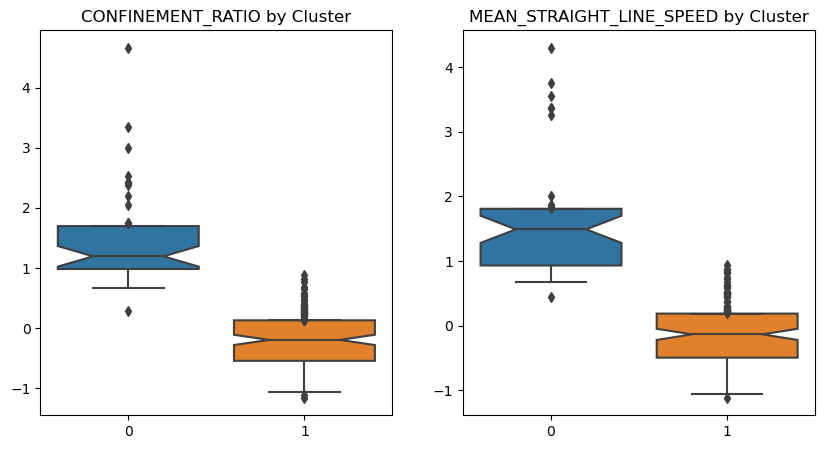

In [30]:
plot_boxplot_sns(df_after_kmeans, 'kmeans')

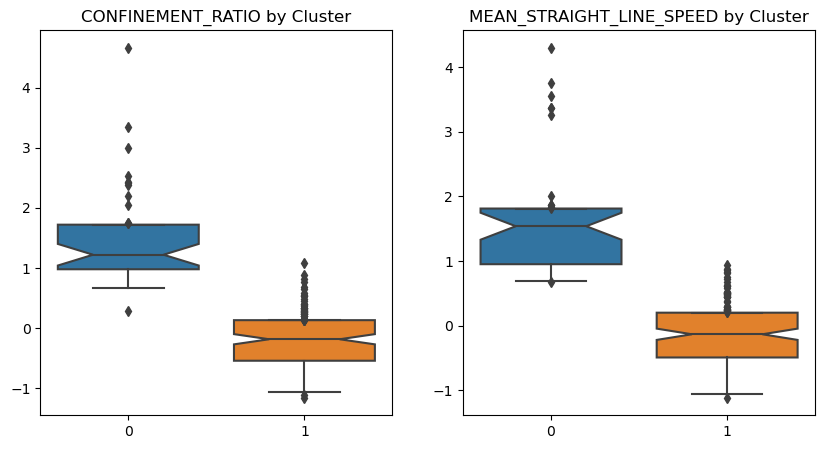

In [31]:
plot_boxplot_sns(df_after_hierarchical, 'hierarchical')

### Preapring spots data frame from raw:

In [32]:
# Now there should be added the parsing of the spots data frame to
# aquire the gruped df of the tracks with all the points accros
# it's movement.

In [33]:
# Creating data frame with the track label, start_pos, end_pos, track_id
df_track_start_end_info = raw_data[['LABEL', 'TRACK_ID', 
                                'TRACK_START', 'TRACK_STOP']].copy()

# Droping unnecessary rows:
df_track_start_end_info.drop(df_track_start_end_info.index[[0,1,2]],
                              inplace = True)

# Reseting index of the whole data frame:
df_track_start_end_info.reset_index(level = None, drop=True, inplace = True)

# Setting proper types of the cells:
df_start_end_tracks = df_track_start_end_info.iloc[:, 1:4].apply(pd.to_numeric)
df_start_end_tracks['Label'] = df_track_start_end_info['LABEL'].astype('string')

# Performing operations on the .csv file with the information about spots:
df_only_spots = raw_data_spots[['TRACK_ID', 'POSITION_X', 'POSITION_Y',
                                'POSITION_T', 'FRAME']].copy()

# Droping unnecesary rows:
df_only_spots.drop(df_only_spots.index[[0,1,2]], inplace=True)

# Reseting the index of the whole data frame:
df_only_spots.reset_index(level=None, drop=True, inplace = True)

# Setting proper types:
df_all_spots = df_only_spots.iloc[:, 0:5].apply(pd.to_numeric)

In [34]:
# Joining two tables on track_id:
df_spots_merged = pd.merge(df_start_end_tracks, df_all_spots, how = 'inner',
                          on='TRACK_ID',
                          suffixes=['','_'])[['Label', 'TRACK_ID', 'TRACK_START',
                                             'TRACK_STOP', 'FRAME', 'POSITION_X',
                                             'POSITION_Y', 'POSITION_T']]

In [35]:
# Sorting merged data frame by the time position for each track:
gruped_tracks = df_spots_merged.sort_values(['TRACK_ID','POSITION_T'],ascending=True).groupby('TRACK_ID', group_keys=False)
sorted_tracks_df = gruped_tracks.apply(lambda x: x)
sorted_tracks_df.head()

,Label,TRACK_ID,TRACK_START,TRACK_STOP,FRAME,POSITION_X,POSITION_Y,POSITION_T
168,Track_0,0,0.0,499.0,0,62.333506,56.009684,0.0
352,Track_0,0,0.0,499.0,1,62.287140,56.002515,1.0
51,Track_0,0,0.0,499.0,2,62.610697,55.942747,2.0
247,Track_0,0,0.0,499.0,3,62.370648,55.698539,3.0
432,Track_0,0,0.0,499.0,4,62.400544,55.728085,4.0


In [36]:
# After this there should be added function to generating points in straight
# line from the start and finish x,y coords of the tracks

In [37]:
# Making dictionary out of the sorted spots data frame:
def track_positions_dict(spots_df):
    try:
        # checking if provided variable is a data fream
        if not isinstance(spots_df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
        
        # Grouping data from data frame by the track_name:
        grouped_data = spots_df.groupby('Label')
        
        # creating the dictionary with the track name and all its pos_x, 
        # pos_y as tuples:
        result_dict = {name: list(zip(group['POSITION_X'], group['POSITION_Y'])) for name, group in grouped_data}
        
        # returning the result:
        return result_dict
    except Exception as e:
        print(f'An error occurs: {e}')

In [38]:
# Calling function to generate the dictionary of position in track:
track_positions_dict = track_positions_dict(sorted_tracks_df)

# Testing the generated dictionary:
# track_positions_dict['Track_0']

In [39]:
# Function generating coordinates in straight line to the start, end
# coordinates of a track:
def generating_points_in_line(x_A, y_A, x_B, y_B, n_samples):
    try:
        # Chceking if provided coordinates are in vertical line:
        if x_A == x_B: # vertical line
            y_values = [y_A + i*(y_B-y_A)/(n_samples-1) for i in range(n_samples)]
            x_values = [x_A] * n_samples
        
        else: # non-vertical line
            x_values = [x_A + i*(x_B-x_A)/(n_samples-1) for i in range(n_samples)]
            y_values = [y_A + i*(y_B-y_A)/(n_samples-1) for i in range(n_samples)]

        # make sure first and last points are (x_A, y_A) and (x_B, y_B) respectively
        x_values[0] = x_A
        y_values[0] = y_A
        x_values[-1] = x_B
        y_values[-1] = y_B

        # create a list of tuples representing the generated points
        points = [(x_values[i], y_values[i]) for i in range(n_samples)]

        return points
    except Exception as e:
        print(f'An error occurs: {e}')

In [40]:
def generate_straight_line_for_all_tracks(tracks_dict: dict, df_start_end_tracks):
    try:
        # Setting the dictionary to stroe output of positions
        # and the name of track:
        track_in_line_pos_dict = {}
        
        # Iterate throught the tracks_dict keys:
        for name in tracks_dict.keys():
            # Setting the name variable:
            track_name = str(name)
            
            # Cacluclating the number of frames from start to finish of movement:
            df = df_start_end_tracks.copy()
            df = df.set_index('Label')
            start_frame = df.loc[track_name, 'TRACK_START'].astype('int32')
            end_frame = df.loc[track_name, 'TRACK_STOP'].astype('int32')
            
            # There have to be +1 addition in case to get all occurances 
            # of moving from first frame to last for example if track
            # starts moving in 0 frame and end in 200 frame function need
            # to generate 201 positions to cover all movemnt frames:
            move_frames = (end_frame-start_frame) + 1
            
            # Getting start and end coordinates:
            list_of_coords = tracks_dict[track_name]
            start_coords = list_of_coords[0]
            end_coords = list_of_coords[-1]
            
            # setting the start position variables:
            start_x, start_y = start_coords
            
            # setting the end positions:
            end_x, end_y = end_coords
            
            # Calling function to generate points in line to return each positions:
            tracks_move_in_line_list = generating_points_in_line(start_x, start_y, end_x, end_y, move_frames)
            
            # Adding all the lists to dict with the proper track names:
            track_in_line_pos_dict[str(name)]= tracks_move_in_line_list
            
        return track_in_line_pos_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [41]:
# Calling function to generate the line positions for all tracks:
straight_tracks_dict = generate_straight_line_for_all_tracks(track_positions_dict, df_start_end_tracks)

# Test checking of dictionary:
#straight_tracks_dict['Track_0']

### Functions calculating distances:

#### Function calculating total euclidean distance:

In simpler terms function will compare the each coordinate x,y points with the generated linear cunterpart generated inprevious steps. This functions need to get the trajectories of the same length. In the proces it calculates the euclidean distance with each point and add them together. Overall return the total euclidean distance. Total distance is the sum of all the distances calculated during operation among the points of both tracks. 

If the two compared trajectories are the same then total distance returned should be zero. Overall distance obtained describes the differences in realtion to the trajectory, which is a straight line with the same start nad end points as the analyzed path. 

In [42]:
import math
# Function performing euclidean distance:
def euclidean_distance(p1, p2):
    '''
    Calculate the Euclidean distance between two points.
    '''
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Function performing total euclidean distance calculations:
def total_euclidean_distance(first_list_of_points, second_list_of_points):
    """
    Calculate the total Euclidean distance between a series of points.
    """
    if len(first_list_of_points) != len(second_list_of_points):
        raise ValueError('The two series of points have different lengths')
    else:
        distance = 0
        for i in range(len(first_list_of_points)):
            distance += euclidean_distance(first_list_of_points[i], second_list_of_points[i])
        
    return distance

# Function performing extracting lists of series of points and calling 
# functions calculating distance, returning the dictionari with names
# as keys and values of distance as the value:
def euclidean_comparison_original_straight(tracks_dict: dict, straight_tracks_dict: dict):
    # Check if the provided dictionaries have the same names of track to avoid false comparision:
    try: 
        list_of_track_names = list(tracks_dict.keys())
        
        list_of_straight_tracks_names = list(straight_tracks_dict.keys())
    except Exception as e:
        print(f'An error occurred: {e}')
    
    # Checking if the lists have the same content:
    try:
        # Dictionary for return the values of distance and track_names:
        result_dict = {}
        
        set1 = set(list_of_track_names)
        set2 = set(list_of_straight_tracks_names)
        if set1 == set2:
            for name in set1:
                track_series = tracks_dict[name]
                straight_line_series = straight_tracks_dict[name]
                total_distance = total_euclidean_distance(track_series, straight_line_series)
                
                # Commenting wokring print (not needed but still usefull):
                # print(f'Total euclidean distance of {name} track and \nits linear generation: {total_distance}')
                result_dict[str(name)] = float(total_distance)
                
        else:
            print("Provided sets differ which means there could be error in generating points.")
        
        return result_dict
    except Exception as e:
        print(f'An error occurred: {e}')

In [43]:
euclidean_comp_dict = euclidean_comparison_original_straight(track_positions_dict,
                                           straight_tracks_dict)
# Test checking:
# euclidean_comp_dict['Track_0']

#### Function performing Dynaming Time Warping:

Algorithm DTW finds optimal aligment beetwen two provided trajectories by matchin each point of one trajectory to the corresponding point of the other. 

The output of function is the distance between trajectories and optimal aligment between two trajectories. 

In [44]:
from typing import Dict, List, Tuple
from dtw import *
from scipy.spatial.distance import euclidean

def dtw_comparison_original_straight(tracks_dict: Dict[str, List[Tuple[float, float]]], straight_tracks_dict: Dict[str, List[Tuple[float, float]]]) -> Dict[str, float]:
    '''
    Function calculates the distance with the DTW (Dinamic Time Warping) algorithm.
    Distance is calculated from provided dictionaries containing the track name, list of 
    coordinates in the from of tuple for both original and lineary generated trajectories. 
    
    Args:
    - tracks_dict (dict): Dictionary with track name and the list of coordinates from start to finish of movement in form of tuple
    - straight_tracks_dict (dict): Same as tracks_dict but contains generated trajectories which are linear and have the same number of 
        points as original trajectories
        
    Returns:
    - resutl_dict (dict): Dictionary containing the values of the distance calcualted by DTW, which describes the distance of original trajectory
        to their linear cunterpart generated in previous steps. 
    '''
    try:
        # Setting dict for the results
        result_dict = {}
        
        # Iterating throught the dict_keys both dicts contains the same 
        # keys in it:
        for name in tracks_dict.keys():
            if name in straight_tracks_dict.keys():
                x = tracks_dict[name]
                y = straight_tracks_dict[name]
                ds = dtw(x, y, dist_method='euclidean')
                
                # Returnig of the DTW result distance for each trajectory
                # to their linear cunterpart
                result_dict[name] = ds.distance
            else:
                print(f"Warning: no straight track found for {name}")

        return result_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [45]:
dtw_dict = dtw_comparison_original_straight(track_positions_dict,
                                            straight_tracks_dict)
# Testing the output:
# dtw_dict

#### Comparing the values of distances to the linear trajectory:

In [46]:
# Comparing distances into single data frame:
df_distances_to_linear = pd.DataFrame(list(euclidean_comp_dict.values()),
                                      index=euclidean_comp_dict.keys(),
                                      columns=['Euclidean_distance'])

# Creating new series from dtw_dictionary:
dtw_distance = pd.Series(dtw_dict, name = 'DTW_distance')

# Adding new column
df_distances_to_linear = pd.concat([df_distances_to_linear, dtw_distance], axis = 1)

# Saving data frame to the .csv file
df_distances_to_linear.to_csv('distances_after_clustering.csv')

In [47]:
def assign_clusters_to_df(df, cluster_dict, column_name):
    """
    Assigns binary values to each track based on their cluster membership
    as given in the cluster_dict and adds a new column to the DataFrame
    
    Args:
    df (pd.DataFrame): The DataFrame to which the cluster labels are to be added
    cluster_dict (dict): A dictionary containing the cluster membership of each track
    column_name (str): The name of the new column to be added
    
    Returns:
    pd.DataFrame: The updated DataFrame with a new column added containing the cluster labels
    """
    # Create a new column named kmeans_clusters filled with 0
    df[column_name] = 0
    
    # Iterate through each cluster in the dictionary
    for k, v in cluster_dict.items():
        # Get the index of the tracks in the current cluster
        cluster_idx = df.index.isin(v)
        # Assign 1 to the kmeans_clusters column for tracks in the current cluster
        df.loc[cluster_idx, column_name] = k
        
    return df

In [48]:
# Calling with the kmeans_dict:
df_distances_to_linear = assign_clusters_to_df(df_distances_to_linear,
                                               kmeans_dict,
                                               'kmeans_clusters')
# Calling with the hierarchical_dict:
df_distances_to_linear = assign_clusters_to_df(df_distances_to_linear,
                                               hierarchical_dict,
                                               'hierarchical_clusters')

# Saving data frame to the .csv file
df_distances_to_linear.to_csv('distances_after_clustering_assigned.csv')

In [49]:
df_distances_to_linear

,Euclidean_distance,DTW_distance,kmeans_clusters,hierarchical_clusters
Track_2499,65.152462,76.862596,1,1
Track_958,1291.529700,390.584617,0,0
Track_198,114.754590,114.071831,1,1
Track_2420,128.914855,98.686353,1,1
Track_2667,71.431615,83.256359,0,0
...,...,...,...,...
Track_1276,397.298924,347.434856,1,1
Track_563,279.825216,426.442728,0,0
Track_2139,52.615708,55.552725,1,1
Track_1954,168.048359,119.213215,1,1


#### Comapring distances among the groups from clustering:

In [50]:
def cluster_distance_stats(cluster_dict: dict, df: pd.DataFrame):
    """
    Calculates the mean, median, and standard deviation of distance values for each cluster
    in the provided dictionary of cluster labels and track names

    Args:
    - cluster_dict (dict): Dictionary with cluster labels as keys and lists of track names as values
    - df (pandas.DataFrame): DataFrame with distance values for each track

    Returns:
    - stats_dict (dict): Dictionary with cluster labels as keys and a tuple of mean, median, and
                         standard deviation of distance values for each cluster as values
    """
    try:
        # Check if the 'Euclidean_distance' and 'DTW_distance' columns are present in the data frame
        if 'Euclidean_distance' not in df.columns or 'DTW_distance' not in df.columns:
            raise ValueError("Data frame does not have the required distance columns.")

        stats_dict = {}

        for cluster_label, track_list in cluster_dict.items():
            # Select the rows of the DataFrame corresponding to the tracks in the current cluster
            cluster_df = df.loc[track_list]

            # Calculate the mean, median, and standard deviation of the distance values for the current cluster
            euclidean_mean = np.mean(cluster_df['Euclidean_distance'])
            euclidean_median = np.median(cluster_df['Euclidean_distance'])
            euclidean_std = np.std(cluster_df['Euclidean_distance'])

            dtw_mean = np.mean(cluster_df['DTW_distance'])
            dtw_median = np.median(cluster_df['DTW_distance'])
            dtw_std = np.std(cluster_df['DTW_distance'])

            # Add the mean, median, and standard deviation to the dictionary for the current cluster
            # in form of dictionaries of each distance taken:
            stats_dict[cluster_label] = {
                'euclidean' : {'mean': euclidean_mean, 'median': euclidean_median,
                              'std': euclidean_std},
                'dtw': {'mean': dtw_mean, 'median': dtw_median, 'std': dtw_std}
            }
            #stats_dict[cluster_label] = ((euclidean_mean, euclidean_median, euclidean_std),
            #                             (dtw_mean, dtw_median, dtw_std))

        return stats_dict
    
    except Eception as e:
        print(f'An error occurs: {e}')

In [51]:
# Calling the function to get the statistics of the distances for each cluster:
kmeans_groups_stats = cluster_distance_stats(kmeans_dict,
                                             df_distances_to_linear)
# Checking the content of dictionary:
# kmeans_groups_stats

# Performing the same operation for the hierarchical cluster dictionary:
hierarchical_groups_stats = cluster_distance_stats(hierarchical_dict,
                                                  df_distances_to_linear)

In [52]:
def group_tracks_by_cluster(df: pd.DataFrame, cluster_column: str):
    """
    Groups the tracks in the DataFrame by the cluster label in the specified column.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the tracks and their cluster labels.
        cluster_column (str): The name of the column containing the cluster labels.
    
    Returns:
        dict: A dictionary where the keys are cluster labels (as integers) and the values are dictionaries
              where the keys are the track indices and the values are dictionaries where the keys are
              'Euclidean_distance' and 'DTW_distance' and the values are the corresponding distances.
    """
    try:
        # Create an empty dictionary to store the clusters
        clusters = {}

        # Iterate through each row in the DataFrame
        for index, row in df.iterrows():
            # Get the cluster label for the current track
            cluster_label = int(row[cluster_column])

            # Check if the current cluster label already exists in the dictionary
            if cluster_label not in clusters:
                # If it doesn't exist, create a new dictionary for the current cluster label
                clusters[cluster_label] = {}

            # Add a dictionary containing the Euclidean and DTW distances to the dictionary for the current track
            clusters[cluster_label][index] = {
                'Euclidean_distance': row['Euclidean_distance'],
                'DTW_distance': row['DTW_distance']
            }

        return clusters 
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [53]:
# Calling of the function to get the distances dictionaries:
kmeans_groups_distances = group_tracks_by_cluster(df_distances_to_linear, 
                                                 'kmeans_clusters')

# Calling same function to get hierarchical groups:
hierarchical_groups_distances = group_tracks_by_cluster(df_distances_to_linear,
                                                       'hierarchical_clusters')

#### Ploting the metrics of distances among the cluster groups:

In [54]:
def plot_dict_w_stats(dict_w_stats: dict, algorithm_name: str):
    '''
    Plot the metrics (mean, median, std) of the distances among groups
    
    Args:
    - dict_w_stats - dictionary of dictionary containing the statistics calculated
        for distances
    - algorithm_name - string containing the name of the algorithm used should be in pair
        with the used dictionary to avoid confusing output
    
    Returns:
    - None, function is performing plotting operation and seving the figure as .png file
    '''
    try:
        # define the x-axis labels
        x_labels = ['euclidean_mean', 'euclidean_median', 'euclidean_std',
                    'dtw_mean', 'dtw_median', 'dtw_std']

        # define the x-axis positions for each label
        x_pos = np.arange(len(x_labels))

        # define the width of each bar
        bar_width = 0.2

        # create a figure and axis object
        fig, ax = plt.subplots()

        # plot the data for each group
        for i, (cluster_label, stats_dict) in enumerate(dict_w_stats.items()):
            # define the y-axis values
            y_values = [stats_dict['euclidean']['mean'], stats_dict['euclidean']['median'],
                        stats_dict['euclidean']['std'], stats_dict['dtw']['mean'],
                        stats_dict['dtw']['median'], stats_dict['dtw']['std']]

            # define the x-axis positions for the current group
            x_pos_cluster = x_pos + (i * bar_width) - (bar_width * (len(dict_w_stats) / 2))

            # plot the data for the current group
            ax.bar(x_pos_cluster, y_values, bar_width, label=f'Cluster {cluster_label}')

        # add axis labels, a title, and a legend
        ax.set_xlabel('Distance Metric and Statistic')
        ax.set_ylabel('Value')
        ax.set_title(f'{algorithm_name} - Metrics by Clusters')
        ax.legend()

        # set the x-axis ticks and labels
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels)

        # setting the names on the x axis slighly angled to avoid names_overlapping:
        plt.xticks(rotation = -20, ha='center')
        
        # saving the fig as the png.file:
        plt.savefig(f'{algorithm_name}_distance_metrics_barplot.png')
        
        # display the plot
        plt.show()
        
    except Exception as e:
        print(f'An error occured: {e}')

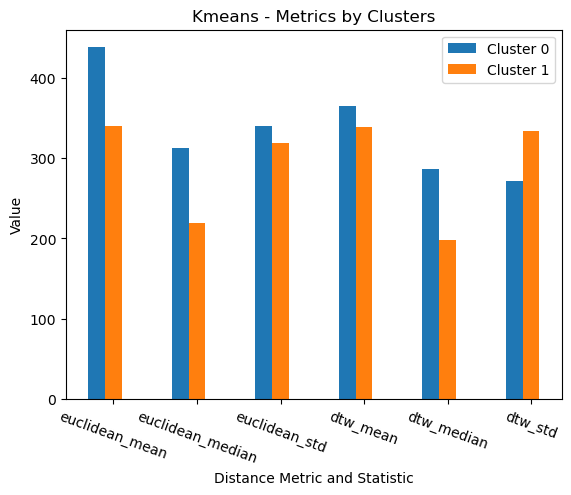

In [55]:
plot_dict_w_stats(kmeans_groups_stats, 'Kmeans')

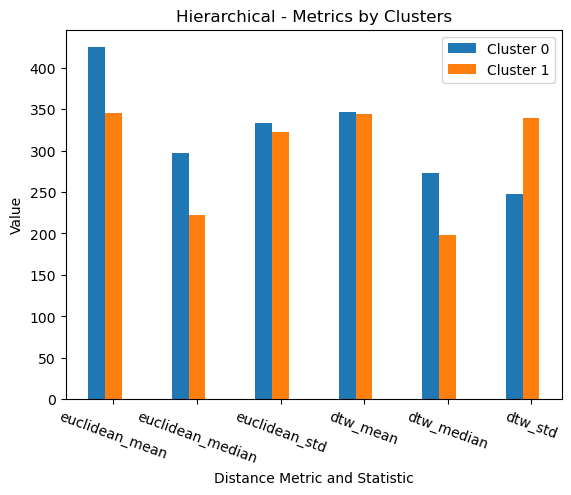

In [56]:
plot_dict_w_stats(hierarchical_groups_stats, 'Hierarchical')

#### Plotting trajectories amnogs the clusters:

In [57]:
def plot_first_three_paths(tracks_in_clusters: dict, dict_w_coords: dict, dict_w_straight_corrds: dict):
    try:
        # Setting opperating dictionary:
        temp_dict = {}
        
        # Choosing the first 3 occurences of each group:
        for key in tracks_in_clusters.keys():
            temp_dict[key] = tracks_in_clusters[key][:3]
        
        # Plotting all the paths:
        for key in temp_dict:
            print(f'Paths from cluster {int(key)}:')
            for name in temp_dict[key]:
                # first_list:
                x_values, y_values = zip(*dict_w_coords[str(name)])
                # Second_list:
                x_2, y_2 = zip(*dict_w_straight_corrds[str(name)])

                # Creating a scatter:
                plt.plot(x_values, y_values, linestyle= 'dashed', label = f'Original {name}')
                plt.plot(x_2, y_2, linestyle='dashed', label = 'Genereted line')
                plt.xlabel('X_coords')
                plt.ylabel('Y_coords')
                plt.legend()
                plt.title(f'Movement path of {name}')
                plt.savefig(f'path_{name}_ass_clust_{key}.png')

                plt.show()
                
    except Exception as e:
        print(f'An error occurs: {e}')

Paths from cluster 0:


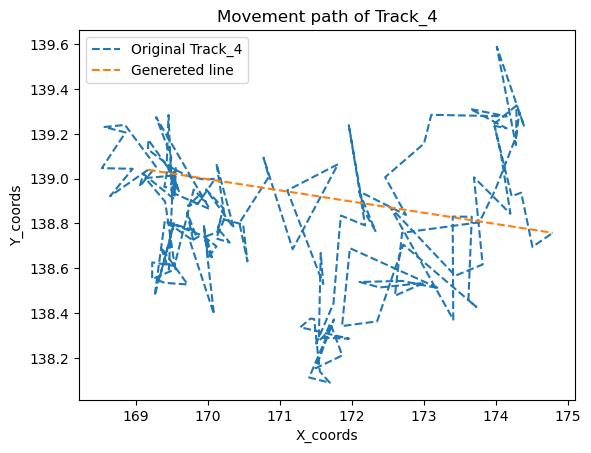

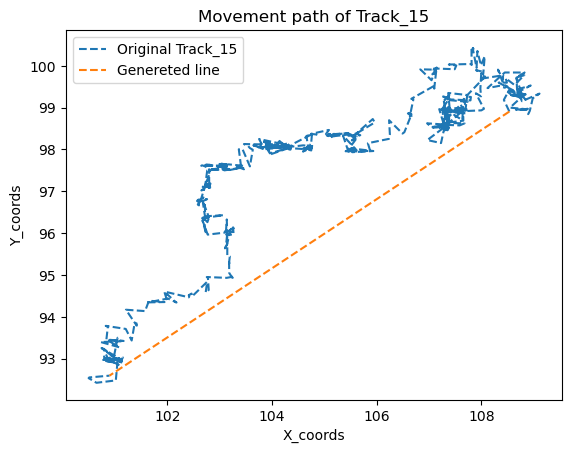

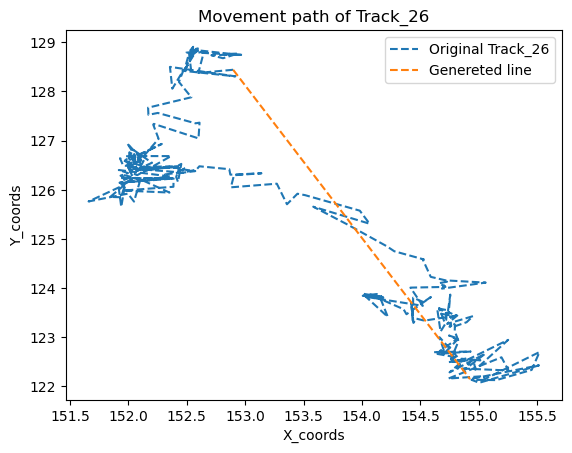

Paths from cluster 1:


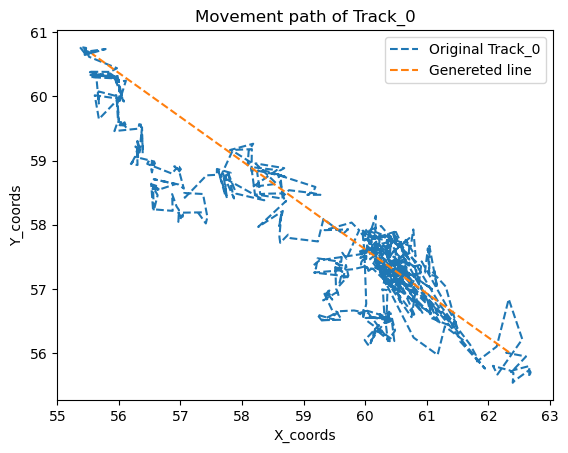

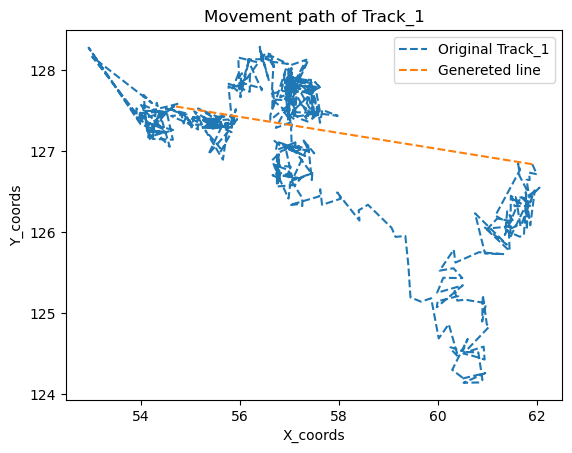

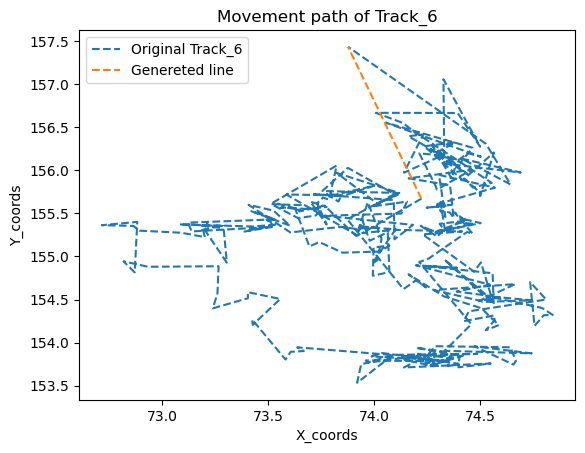

In [58]:
plot_first_three_paths(kmeans_dict, track_positions_dict, straight_tracks_dict)

### Check if provided features within groups are statistically significant

In [59]:
def check_normality_and_variance_equality(df_after_clustering, feature_list, cluster_col='Cluster_labels'):
    """
    This function splits the input dataframe by the cluster for each feature, 
    performs normality and variance equality check for each group, 
    and returns a dictionary with results for each feature.
    
    Parameters:
    - df_after_clustering: pandas dataframe containing the data
    - feature_list: list of strings containing the names of the features to check
    - cluster_col: string, the name of the column containing the cluster labels
    
    Returns:
    - A dictionary containing the results for each feature, with feature names as keys.
      Each result is a dictionary containing p-values of normality and variance equality tests
      for each cluster group, with cluster labels as keys.
    """
    try:
        result_dict = {}

        for feature in feature_list:
            # Split the data by cluster and select the current feature
            cluster_groups = df_after_clustering.groupby(cluster_col)[feature]

            # Perform normality test for each group using Shapiro-Wilk test
            shapiro_results = cluster_groups.apply(lambda x: stats.shapiro(x)[1])

            # Perform variance equality test using Levene's test
            levene_results = stats.levene(*[group for _, group in cluster_groups])

            # Store results in the dictionary
            result_dict[feature] = {'0': {'shapiro': shapiro_results.loc[0], 'levene': levene_results.pvalue},
                                    '1': {'shapiro': shapiro_results.loc[1], 'levene': levene_results.pvalue}}

        return result_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [60]:
# Adding the print for column_names if needed to change in future in place:
column_names_provided_df = list(df_after_kmeans.columns)
print(f'Available column names:\n{column_names_provided_df}')

Available column names:
['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED', 'Cluster_labels']


In [61]:
# Calling function of testing the normality and equality:
normality_equ_dict_kmeans = check_normality_and_variance_equality(df_after_kmeans,
                                 ['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED'])

In [62]:
# Output of the dictionary:
normality_equ_dict_kmeans

{'CONFINEMENT_RATIO': {'0': {'shapiro': 1.4253460904001258e-05,
   'levene': 0.011247349790236739},
  '1': {'shapiro': 0.2297704964876175, 'levene': 0.011247349790236739}},
 'MEAN_STRAIGHT_LINE_SPEED': {'0': {'shapiro': 2.9090122552588582e-05,
   'levene': 6.446067028401855e-05},
  '1': {'shapiro': 0.18889376521110535, 'levene': 6.446067028401855e-05}}}

#### Performing statistical testing if there are sagnificant differences between groups:

In [63]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney(df_after_clustering, feature_list, cluster_col='Cluster_labels', pval_threshold=0.05):
    """
    This function performs the Mann-Whitney U test for the two groups in each feature,
    and checks if the groups differ significantly based on a given p-value threshold.
    
    Parameters:
    - df_after_clustering: pandas dataframe containing the data
    - feature_list: list of strings containing the names of the features to check
    - cluster_col: string, the name of the column containing the cluster labels
    - pval_threshold: float, the p-value threshold to use for significance testing
    
    Returns:
    - A dictionary containing the results for each feature, with feature names as keys.
      Each result is a dictionary with keys 'Statistic', 'P-value', and 'Groups_differ'.
      The 'Groups_differ' key has a value of 'Yes' if the p-value is below the threshold,
      or 'No' otherwise.
    """
    try:
        result_dict = {}
        
        for feature in feature_list:
            # Split the data by cluster and select the current feature
            cluster_groups = df_after_clustering.groupby(cluster_col)[feature]
            
            # Perform Mann-Whitney U test for the two groups
            group1 = cluster_groups.get_group(0)
            group2 = cluster_groups.get_group(1)
            mwu_result = mannwhitneyu(group1, group2, alternative='two-sided')
            
            # Check if the p-value is below the threshold
            if mwu_result.pvalue < pval_threshold:
                groups_differ = 'Yes'
            else:
                groups_differ = 'No'
            
            result_dict[feature] = {'Statistic': mwu_result.statistic,
                                    'P-value': mwu_result.pvalue,
                                    'Groups_differ': groups_differ}
        
        return result_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [64]:
# Calling the function to perform testing:
mann_result_dict = perform_mann_whitney(df_after_kmeans,
                        ['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED'])

In [65]:
mann_result_dict

{'CONFINEMENT_RATIO': {'Statistic': 6587.0,
  'P-value': 3.794617160624072e-23,
  'Groups_differ': 'Yes'},
 'MEAN_STRAIGHT_LINE_SPEED': {'Statistic': 6557.0,
  'P-value': 9.372968160536661e-23,
  'Groups_differ': 'Yes'}}

#### Creating boxplots with annotations of provided features:

In [66]:
from statannotations.Annotator import Annotator

def plot_boxplot_with_annotations(df_after_clustering, cluster_labels = 'Cluster_labels',feature_list = ['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED']):
    '''
    This function perform plotting operations on the pandas data frame data created after clustering. The result of the function are graphs 
    of all the features given in the list of features, as long as they occur in the given data frame. 
    The generated plot is a box plot of each feature in relation to its clustering groups with an annotation 
    informing whether there are statistically significant differences between the groups confirmed by the Mann-Whitney test.
    
    Parameters:
    - df_after_clustering: pandas dataframe containing the data
    - cluster_labels: string name of the column contaning the labels of the clusters
    - feature_list: list of strings containing the names of the features to check
    
    Returns:
    None, this is plotting function, but it saves the plots as a png in working directory.

    '''
    try:
        # Setting the properties of boxplot
        for feature in feature_list:
            fig, ax = plt.subplots(figsize=(8,6))
            # Argument whis = 1.5 to show the whiskers up to 1.5 standard deviations from the 
            # upper and lower quartiles
            sns.boxplot(data = df_after_clustering, x=cluster_labels, y=feature, ax = ax, whis = 1.5)
            ax.set_xlabel('Clusters')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} boxplot')
            ax.set_xticklabels(['Cluster 0', 'Cluster 1'])
            
            # Setting the annotator
            annotator = Annotator(ax, pairs = [(0,1)], data= df_after_clustering,
                                  x=cluster_labels, y=feature)
            annotator.configure(test = "Mann-Whitney")#, text_format = 'simple')
            annotator.apply_and_annotate()
            
            #saving the plots
            plt.savefig(f'{feature}_with_annotation_kmeans.png')
            # Showing the plot
            plt.show()
            
    except Exception as e:
        print(f'An error occurs: {e}')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.795e-23 U_stat=6.587e+03


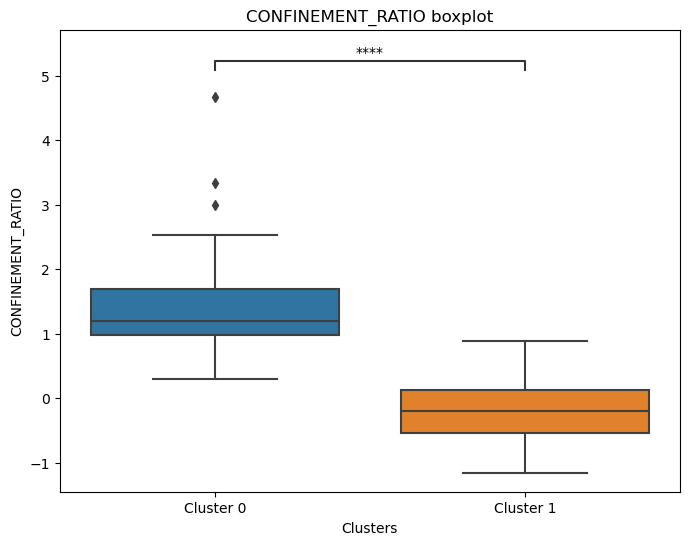

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.373e-23 U_stat=6.557e+03


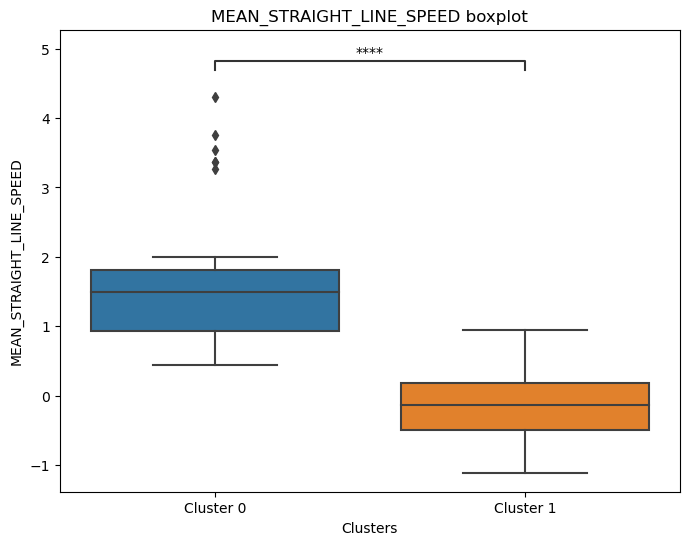

In [67]:
plot_boxplot_with_annotations(df_after_kmeans)

#### Creating boxplots with annotations of calculated distances:

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.928e-02 U_stat=4.032e+03


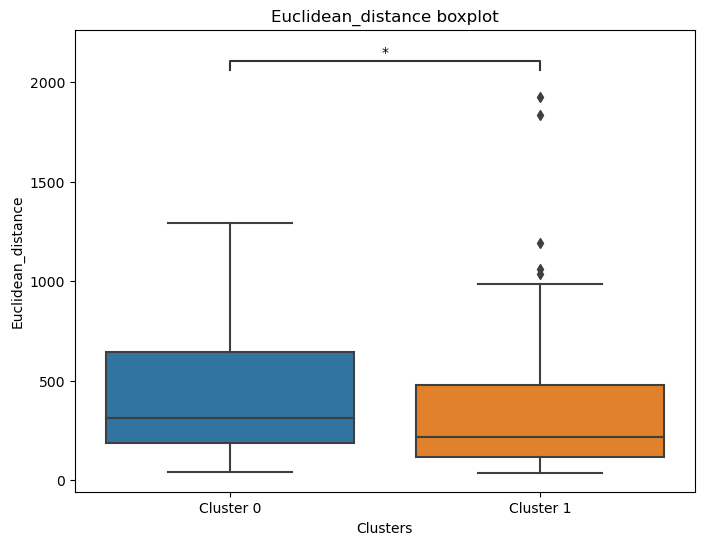

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.582e-01 U_stat=3.778e+03


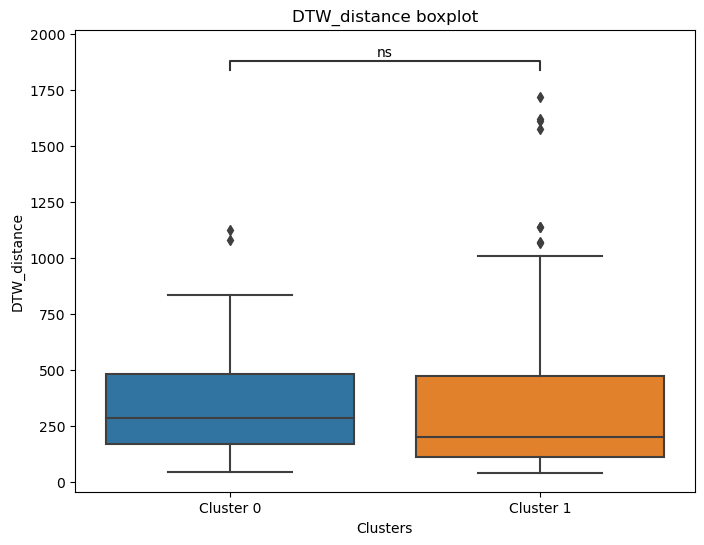

In [68]:
# In use for distances purpose the additiona alrguments should be specified:
# data frame - the proper one with the distances
# column containing informations about clustering labels
# list of feature names in this example the distance names 
# to use as features: 
plot_boxplot_with_annotations(df_distances_to_linear, 'kmeans_clusters',
                             ['Euclidean_distance', 'DTW_distance'])

#### Getting mean_directiona_change_rate data from raw according to groups:

In [69]:
def get_feature_by_track_name(gruped_dict: dict, df_scaled: pd.DataFrame, feature: str):
    '''
    Function creates dictionary of dictionaries splited by the cluster group. The dictionaries
    inside cluster group contain information about the track name and their value of provided 
    as string feature to choose.
    
    Args:
    - gruped_dict: dict - dict with the names of tracks splitted into two groups. In the form 
    of dictionary of dictionaries where first dictionary stroe the information about the cluster
    in the key and the names of tracks in the list.
    
    - df_scaled: pd.DataFrame - pandas data frame with all the features from fjii scaled
    
    - feature: str - string name of the feature from df_scaled, which we want to choose to create
    dictionary from it.
    
    Returns:
    Function returns dictionary of dictionaries where first key is cluster number, second dictionary store
    the info about the track name as a key, and the choosen feature value as flot or int accordingly which 
    feature was selected. 
    
    '''
    try:
        # Dictionary to store the values:
        storing_dict = {}
        
        # Iterating by the dictionary and list of group string to get 
        # proper values:
        for key, name_list in gruped_dict.items():
            temp_key = key
            storing_dict[temp_key] = {}
            for name_index in range(len(name_list)):
                temp_name = name_list[name_index]
                #print(f'Temp Name: {temp_name}')
                
                # selecting column value from choosen row:
                needed_val = df_scaled.loc[df_scaled['Label']==temp_name, str(feature)].values[0]
                # print(f'{temp_name}: {needed_val}')
                
                # Saving the values to the dictionary:
                storing_dict[temp_key][temp_name] = needed_val
                
        return storing_dict
        
    except Exceptions as e:
        print(f'An error occurs: {e}')

In [70]:
change_rate_by_track = get_feature_by_track_name(kmeans_dict, df_scaled, 'MEAN_DIRECTIONAL_CHANGE_RATE')

#### Convertion of provided feature dictionary to data frame:

In [71]:
def dict_to_dataframe(data_dict: Dict[str, Dict[str, float]], value_col_name: str) -> pd.DataFrame:
    """
    Converts a dictionary with nested dictionaries into a Pandas DataFrame with three columns: name, value,
    and group. The name column contains the name of each dictionary key, the value column contains the values
    of the dictionary keys specified by the value_col_name argument, and the group column contains an integer
    indicating which nested dictionary the key belongs to.
    
    Args:
     - data_dict - A dictionary with nested dictionaries.
     - value_col_name - A string specifying the key in the nested dictionaries to use as the values in the
                           "value" column of the resulting DataFrame.
    Returns:
     - A Pandas DataFrame.
    """
    try:
        # Check if the input dictionary is in the proper format
        for name, nested_dict in data_dict.items():
            if not isinstance(nested_dict, dict):
                print(f"Value for key {name} is not a proper form of dictionary.")
                return None
            for key, value in nested_dict.items():
                if not isinstance(value, float):
                    print(f"Value for key {key} in nested dictionary under {name} is not an float.")
                    return None
        
        # Initialize lists for each column
        names = []
        values = []
        groups = []

        # Iterate over the outer dictionary
        for group, group_dict in data_dict.items():
            # Checking values:
            # print(f'Group: {group}')
            # print(f'Group_dict: {group_dict}')
            
            # Iterate over the inner dictionary
            for name, value_dict in group_dict.items():
                # Checking values:
                #print(f'Name: {name}')
                #print(f'Value_dict: {value_dict}')
                
                # Add the name, value, and group to their respective lists
                names.append(name)
                values.append(value_dict)
                groups.append(group)

        # Create a DataFrame from the lists
        df = pd.DataFrame({'name': names, value_col_name: values, 'Clusters': groups})

        return df
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [72]:
change_rate_df = dict_to_dataframe(change_rate_by_track, 'Mean_change_rate')

#### Creating boxplot with annotations for choosen feature:

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.250e-06 U_stat=1.805e+03


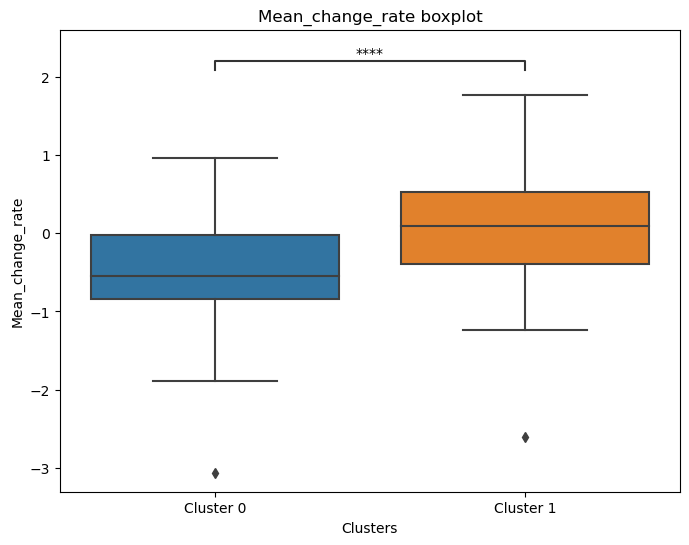

In [73]:
plot_boxplot_with_annotations(change_rate_df, 
                              'Clusters', ['Mean_change_rate'])


### Measuring curvature of movement:

In [74]:
from scipy.interpolate import splprep, splev

def curvature_measurment(tracks_in_clusters: dict, dict_w_coords: dict):
    # tracks_in_clusters: dict generates some errors need further investigation
    # example_paths_dict: dict
    """
    Calculates the curvature of the first three trajectories in each cluster and visualizes them.

    This function uses the `splprep` and `splev` functions from the SciPy library to fit a spline to the trajectory data 
    and evaluate the curvature of the trajectory at each point. The curvature is calculated as the inverse of the radius 
    of the circle that best approximates the trajectory at each point. By convention, the sign of the curvature is 
    positive for curves that bend counterclockwise (to the left) and negative for curves that bend clockwise (to the right).

    The input trajectory data may contain points that are very close to each other, which can cause numerical instability 
    in the spline fitting process. To mitigate this issue, the input trajectory data is first filtered to remove duplicate 
    points that are too close together or repeats according to treshold.

    Args:
        tracks_in_clusters (dict): A dictionary of trajectory names grouped by their respective clusters.
        dict_w_coords (dict): A dictionary with keys as trajectory names and values as a list of (x,y) coordinates.

    Returns:
        None
    """
    try:
        # Setting opperating dictionary:
        temp_dict = {}
        
        # Choosing the first 3 occurences of each group:
        for key in tracks_in_clusters.keys():
            temp_dict[key] = tracks_in_clusters[key][:3]
            
        print(temp_dict)
        
        # Plotting all the paths:
        for key in temp_dict:
            print(f'Paths from cluster {int(key)}:')
            for name in temp_dict[key]:
                # Unpacking trajectory coordinates:
                x, y = zip(*dict_w_coords[str(name)])
                
                # Define a threshold distance (in units of x/y coordinates) below which points are considered duplicates
                threshold = 0.00001

                # Initialize a list to hold the filtered data points
                filtered_x = [x[0]]
                filtered_y = [y[0]]

                # Loop through the data points and filter out duplicates
                for i in range(1, len(x)):
                    dist = np.sqrt((x[i] - filtered_x[-1])**2 + (y[i] - filtered_y[-1])**2)
                    if dist > threshold:
                        filtered_x.append(x[i])
                        filtered_y.append(y[i])

                # Fit a spline to the trajectory data
                tck, u = splprep([filtered_x, filtered_y], s=0)

                # Evaluate the spline to get x and y coordinates at each point along the curve
                x_new, y_new = splev(np.linspace(0, 1, num=len(filtered_x)), tck)

                # Calculate the curvature of the trajectory
                dx_dt, dy_dt = splev(np.linspace(0, 1, num=len(filtered_x)), tck, der=1)
                d2x_dt2, d2y_dt2 = splev(np.linspace(0, 1, num=len(filtered_x)), tck, der=2)
                curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt ** 2 + dy_dt ** 2) ** 1.5

                # Plot the trajectory and curvature
                import matplotlib.pyplot as plt
                fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
                axs[0].plot(x, y)
                axs[0].set_xlabel('X')
                axs[0].set_ylabel('Y')
                axs[0].set_title(f'Trajectory_of_{name}')
                axs[1].plot(curvature)
                axs[1].set_xlabel('Point Number')
                axs[1].set_ylabel('Curvature')
                axs[1].set_title('Curvature')
                fig.subplots_adjust(hspace=0.25)
                plt.title(f'{name}_curavature_measure')
                #saving the plots
                plt.savefig(f'{name}_and_curvature_kmeans.png')
                plt.show()
                
    
    except Exception as e:
        print(f'An error occurs: {e}')

{0: ['Track_4', 'Track_15', 'Track_26'], 1: ['Track_0', 'Track_1', 'Track_6']}
Paths from cluster 0:


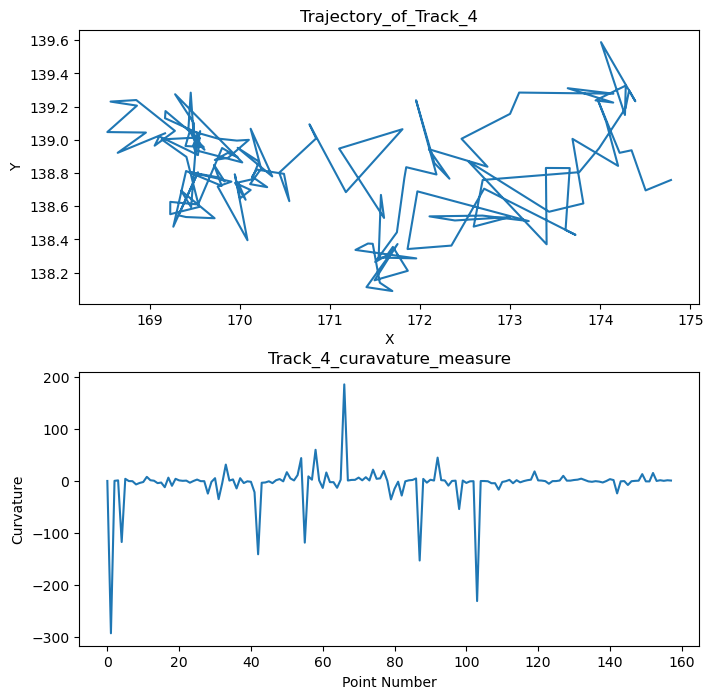

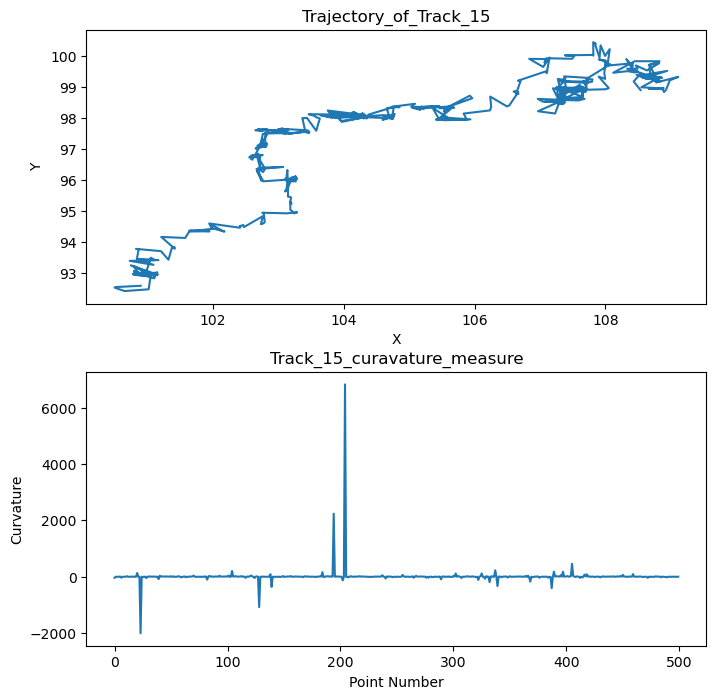

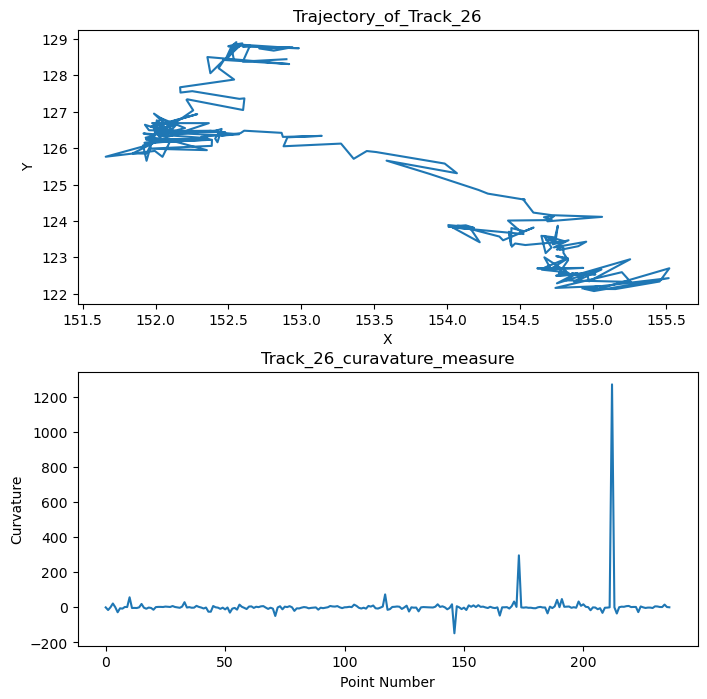

Paths from cluster 1:


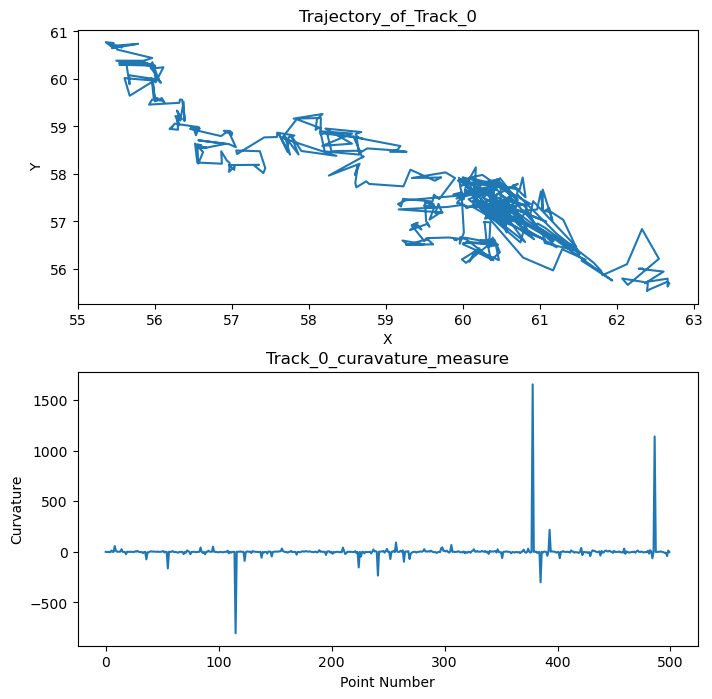

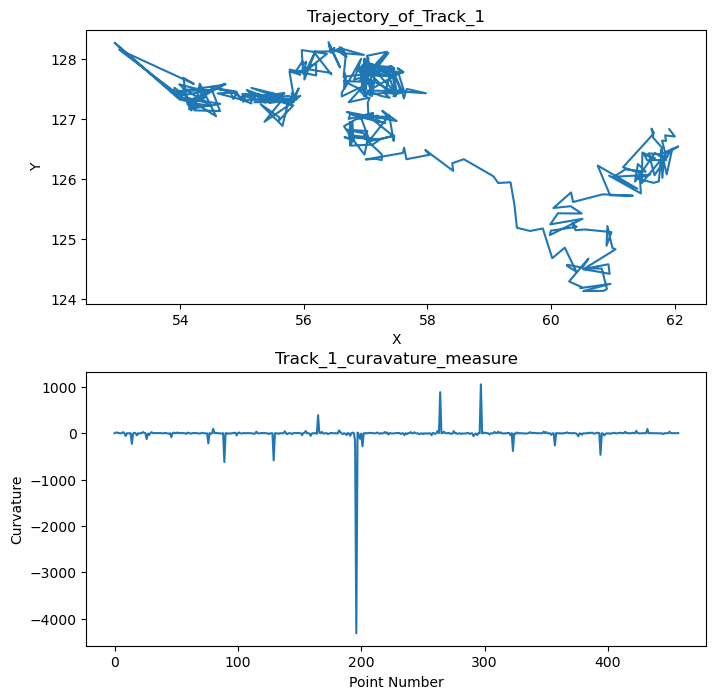

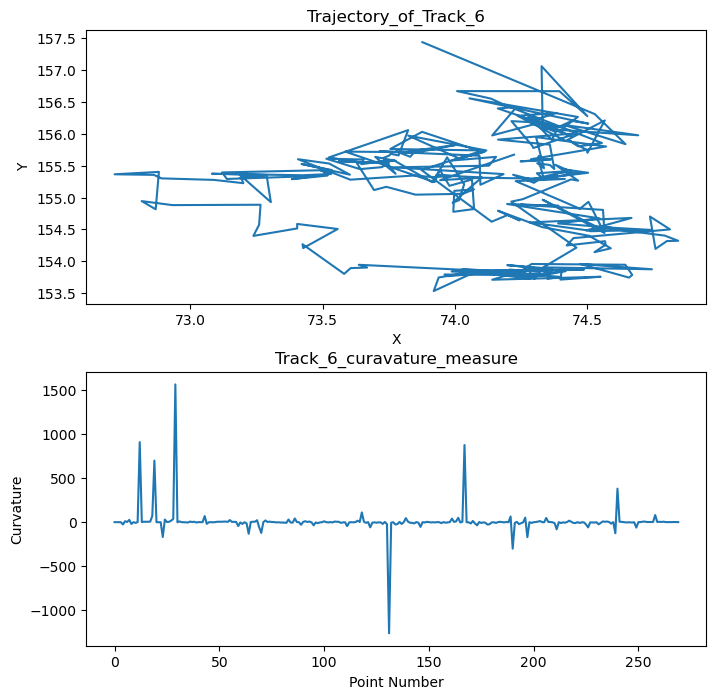

In [75]:
curvature_measurment(kmeans_dict, track_positions_dict)

The curve diagram from the code shows the variation in curvature of the movement path. The curvature determines how much the path of motion is curved at each point. The higher the curvature value, the more the track is curved.

In a curvature diagram, the horizontal axis represents points on the path of motion and the vertical axis represents the value of curvature at these points. Positive values of curvature mean that the track of motion is curved to the right and negative values mean that the track is curved to the left.

The curvature values depend on the scale of the graph, so without an accurate scale it is difficult to determine exactly how much the track is curved. However, by looking at the overall variation of curvature on the graph, we can assess how much the track is curved and where the most curved areas are.

## TEST CODE:

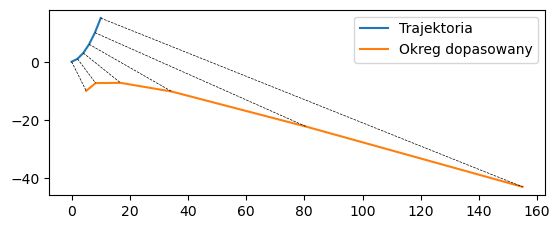

In [76]:
# przykładowe punkty trajektorii
x = np.array([0, 2, 4, 6, 8, 10])
y = np.array([0, 1, 3, 6, 10, 15])

# wyznaczenie krzywizny dla każdego punktu
dx_dt = np.gradient(x)
dy_dt = np.gradient(y)
d2x_dt2 = np.gradient(dx_dt)
d2y_dt2 = np.gradient(dy_dt)
curvature = (dx_dt*d2y_dt2 - dy_dt*d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5

# wyznaczenie promienia dla każdego punktu
radius = 1 / curvature

# wyznaczenie środka okręgu dla każdego punktu
x_center = x + radius * dy_dt / np.sqrt(dx_dt**2 + dy_dt**2)
y_center = y - radius * dx_dt / np.sqrt(dx_dt**2 + dy_dt**2)

# rysowanie trajektorii, okręgu i promienia
fig, ax = plt.subplots()
ax.plot(x, y, label='Trajektoria')
ax.plot(x_center, y_center, label='Okreg dopasowany')
ax.set_aspect('equal')
for i in range(len(x)):
    ax.plot([x[i], x_center[i]], [y[i], y_center[i]], 'k--', lw=0.5)
ax.legend()
plt.show()

#### Test to print something each iteration:

In [77]:
# Setting opperating dictionary:
temp_dict = {}
        
# Choosing the first 3 occurences of each group:
for key in kmeans_dict.keys():
    temp_dict[key] = kmeans_dict[key][:3]

# spliting tracks to lists:
cluster_0 = [item for sublist in temp_dict.values() for item in sublist if sublist in [temp_dict[0]]]
cluster_1 = [item for sublist in temp_dict.values() for item in sublist if sublist in [temp_dict[1]]]

# Showing the lists:
print(f'Cluster_0: {cluster_0}')
print(f'Cluster_1: {cluster_1}')

Cluster_0: ['Track_4', 'Track_15', 'Track_26']
Cluster_1: ['Track_0', 'Track_1', 'Track_6']


In [78]:
# testing input:
try:
    # test:
    x,y = zip(*track_positions_dict[cluster_0[0]])
    track_len = len(track_positions_dict[cluster_0[0]])

    # Sprawdzenie długości tuple
    if len(x) != len(y):
        raise ValueError("Tuple x and y have different lengths")

    # Konwersja na numpy.ndarray
    x = np.array(x)
    y = np.array(y)

    # Sprawdzenie typów danych
    if x.dtype != np.float64 or y.dtype != np.float64:
        raise TypeError("Tuple x and y must contain values of type float")

    # Sprawdzenie, czy x i y zawierają niezerowe wartości
    if np.any(x == 0) or np.any(y == 0):
        raise ValueError("Tuple x and y must not contain zero values")
except Exception as e:
    print(f'{e}')

158
158
158


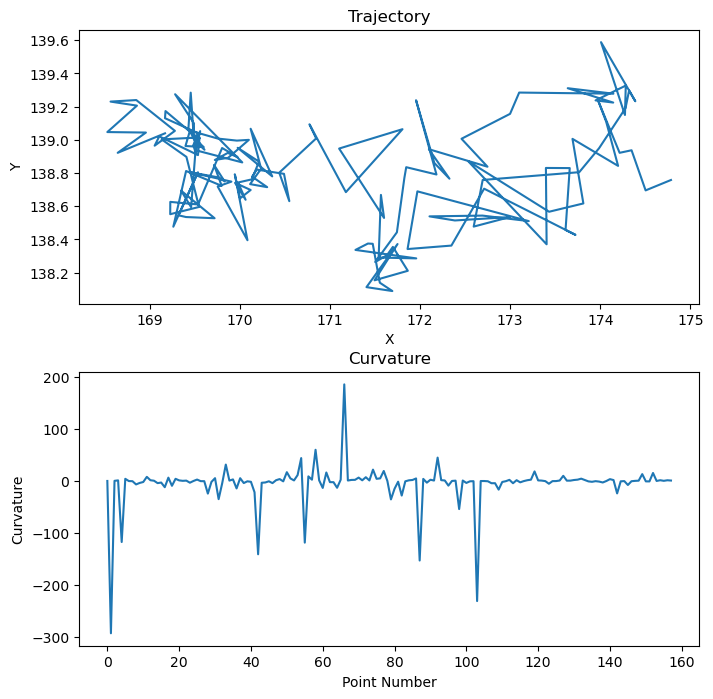

In [79]:
from scipy.interpolate import splprep, splev

"""
This code uses the scipy library to fit a spline to a given trajectory, and then calculates the curvature of the trajectory using the fitted spline. The steps are as follows:

Import the required libraries - scipy.interpolate.splprep and scipy.interpolate.splev.
Create a set of x and y coordinates to represent the trajectory (in this example, 
the data is taken from a dictionary called track_positions_dict for a specific track named 'Track_2').
Fit a spline to the trajectory data using splprep. The s parameter controls the smoothness of the resulting spline. 
A value of 0 means the spline will pass through all the given points, 
while a higher value will result in a smoother curve that may not pass through all the points.
Evaluate the fitted spline using splev to obtain new x and y coordinates at a higher resolution 
(1000 points in this example). Calculate the curvature of the trajectory using the formula 
for curvature based on the first and second derivatives of the spline.
Plot the original trajectory and the curvature values on two subplots.

Args:
None

Returns:
None

"""

# test:
x,y = zip(*track_positions_dict[cluster_0[0]])
track_len = len(track_positions_dict[cluster_0[0]])

# test to change to np.array:
x, y = np.array(x), np.array(y)

# Define a threshold distance (in units of x/y coordinates) below which points are considered duplicates
threshold = 0.00001

# Initialize a list to hold the filtered data points
filtered_x = [x[0]]
filtered_y = [y[0]]

# Loop through the data points and filter out duplicates
for i in range(1, len(x)):
    dist = np.sqrt((x[i] - filtered_x[-1])**2 + (y[i] - filtered_y[-1])**2)
    if dist > threshold:
        filtered_x.append(x[i])
        filtered_y.append(y[i])

# test of length:
print(len(x))
print(len(filtered_x))
print(len(filtered_y))
# Fit a spline to the trajectory data
tck, u = splprep([filtered_x, filtered_y], s=0)

# Evaluate the spline to get x and y coordinates at each point along the curve
x_new, y_new = splev(np.linspace(0, 1, num=len(filtered_x)), tck)

# Calculate the curvature of the trajectory
dx_dt, dy_dt = splev(np.linspace(0, 1, num=len(filtered_x)), tck, der=1)
d2x_dt2, d2y_dt2 = splev(np.linspace(0, 1, num=len(filtered_x)), tck, der=2)
curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt ** 2 + dy_dt ** 2) ** 1.5

# Plot the trajectory and curvature
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axs[0].plot(x, y)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Trajectory')
axs[1].plot(curvature)
axs[1].set_xlabel('Point Number')
axs[1].set_ylabel('Curvature')
axs[1].set_title('Curvature')
fig.subplots_adjust(hspace=0.25)
plt.show()

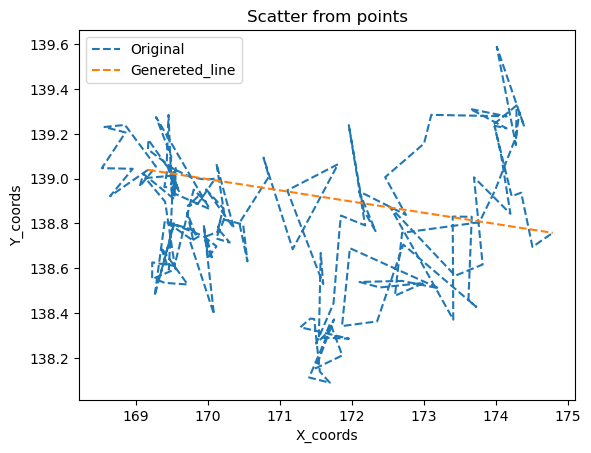

In [80]:
# Testing the generation of points:
# first_list:
x_values, y_values = zip(*track_positions_dict[cluster_0[0]])
# Second_list:
x_2, y_2 = zip(*straight_tracks_dict[cluster_0[0]])

# Creating a scatter:
plt.plot(x_values, y_values, linestyle= 'dashed', label = 'Original')
plt.plot(x_2, y_2, linestyle='dashed', label = 'Genereted_line')
plt.xlabel('X_coords')
plt.ylabel('Y_coords')
plt.legend()
plt.title('Scatter from points')

plt.show()

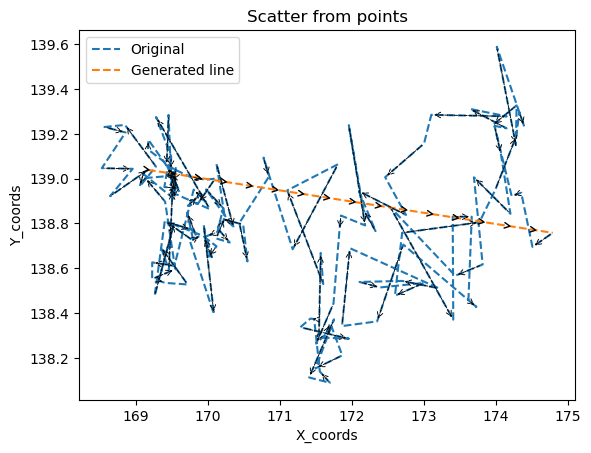

In [81]:
# First list:
x_values, y_values = zip(*track_positions_dict[cluster_0[0]])
# Second list:
x_2, y_2 = zip(*straight_tracks_dict[cluster_0[0]])

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the original track and generated line
ax.plot(x_values, y_values, linestyle='dashed', label='Original')
ax.plot(x_2, y_2, linestyle='dashed', label='Generated line')

# Add annotations to the generated line
for i in range(0, len(x_2) - 1, 10):
    if i % 2 == 0:  # Add between first and last pair
        ax.annotate('', xy=(x_2[i+1], y_2[i+1]), xytext=(x_2[i], y_2[i]),
                    arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1,
                                linestyle='--'))
        
for i in range(len(x_values) - 1):
    if i == 0 or i == len(x_values) - 2:  # Add between first and last pair
        ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                    arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1,
                                linestyle='None'))
        
# Adding arrow each every pair of points, this will be achived changing the step
# inside the for loop:

#for i in range(0, len(x_values) - 1, 2):
#    ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
#                arrowprops=dict(facecolor='black', width=0.95, headwidth=2.5))
#    

# Add annotations to the generated line
for i in range(len(x_values) - 1):
    if i % 2 == 0:  # Add arrow every other point
        ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                    arrowprops=dict(facecolor='black', arrowstyle='<-', linewidth=0.65,
                                linestyle='--'))

# Add axis labels, title and legend
ax.set_xlabel('X_coords')
ax.set_ylabel('Y_coords')
ax.set_title('Scatter from points')
ax.legend()

plt.show()

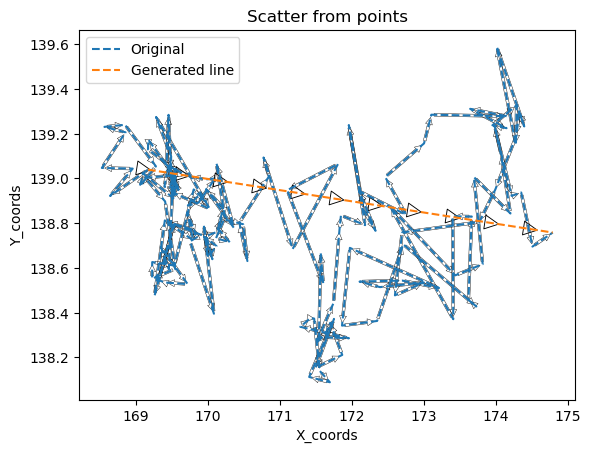

In [82]:
import matplotlib.patches as patches

# Testing the generation of points:
# First list:
x_values, y_values = zip(*track_positions_dict[cluster_0[0]])
# Second list:
x_2, y_2 = zip(*straight_tracks_dict[cluster_0[0]])

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the original track and generated line
ax.plot(x_values, y_values, linestyle='dashed', label='Original')
ax.plot(x_2, y_2, linestyle='dashed', label='Generated line')

# Add annotations to the generated line
for i in range(0, len(x_2) - 1, 15):
    start = (x_2[i], y_2[i])
    end = (x_2[i+1], y_2[i+1])
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    arrow = patches.FancyArrowPatch(start, end, arrowstyle='simple',
                                    mutation_scale=20, linewidth=0.65, 
                                    edgecolor='black',
                                    facecolor='none')
    ax.add_patch(arrow)
    
for i in range(0, len(x_values) - 1):
    start = (x_values[i], y_values[i])
    end = (x_values[i+1], y_values[i+1])
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    arrow_values = patches.FancyArrowPatch(start, end, arrowstyle='simple',
                                    mutation_scale=10, linewidth=0.3, 
                                    edgecolor='black',
                                    facecolor='none')
    ax.add_patch(arrow_values)
    
# Add axis labels, title and legend
ax.set_xlabel('X_coords')
ax.set_ylabel('Y_coords')
ax.set_title('Scatter from points')
ax.legend()

plt.show()